# BE/Bi 205: Assignment 1 Notebook
## Anna Lapteva

Below are all relevant imports, sourced from the [assignment instructions](https://vanvalenlab.github.io/bebi205/assignments/assignment-1.html), the [image processing notebook](https://vanvalenlab.github.io/bebi205/notebooks/tf-classifier.html), and the tutorial on [multiclass classification in PyTorch](https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/).

In [1]:
# Computation and data handling
import numpy as np
import pandas as pd
import yaml
import os
import glob
from tqdm import tqdm
from tqdm import trange
import copy

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Neural network
import skimage
from skimage import measure
import sklearn.model_selection
import skimage.color
import skimage.transform

import tensorflow as tf
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model

import torch
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim

2023-04-24 08:17:28.452042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 08:17:28.508751: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 08:17:28.509765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 08:17:29.309793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-24 08:17:30.008027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

Since the map from cell number to type is used throughout this notebook, I will load it here.

In [2]:
with open("keren/meta.yaml", "r") as stream:
    try:
        metadata = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

I will also load the data from the .npz files in the keren folder so that we can easily use it later.

In [3]:
directory = "./keren/"
data_files = os.chdir(directory)
npz_data = [file for file in glob.glob("*.npz")]

### Marker Expression Plot

I'll define functions that make our life easier for loading in and processing the data used for the marker expression plot.

In [4]:
def get_file(file):
    '''Load .npz file from list of files in keren.'''
    with np.load(file, allow_pickle=True) as data:
        X = data["X"]
        y = data["y"]
        cell_types = data["cell_types"].item()
    return X, y, cell_types
        
        
def normalize_data(X):
    '''Normalize X data by dividing data within channel by maximum value of that channel.'''
    flattened_X = np.reshape(X[0], (X[0].shape[0]*X[0].shape[1], X[0].shape[2]))
    maxValsX = np.max(flattened_X, axis=0)
    maxValsX[maxValsX == 0] = 1
    return X / maxValsX


def training_DF(normalized_X, y, cell_types):
    '''Create training DataFrame from nuclear segmentation data and normalized X data.'''
    # Retrieve nuclear segmentation data
    cellData = y[0,...,0]
    
    # Create DataFrame of mean intensities
    df1 = pd.DataFrame(
    measure.regionprops_table(cellData, intensity_image=normalized_X[0], properties=['label','mean_intensity'],
    )).set_index('label')
    
    # Add cell types
    cellTypes = np.array([cell_types[i] for i in df1.index.values])
    df1["cell type"] = cellTypes
    
    # Add channel names
    dictChannels = {}
    for j in range(len(metadata['channels'])):
        dictChannels[df1.columns.values[j]] = metadata['channels'][j]

    # Rename columns to channel names
    df2 = df1.rename(columns=dictChannels)
    
    return df2

def generate_training_df(list_files):
    '''Put everything together to generate final training dataset containing data from all files.'''
    # Initialize counter for data-generating purposes
    counter = 0
    
    # Iterate through files in list
    for file in tqdm(list_files):
        counter += 1
        X, y, cell_types = get_file(file)
        
        # Normalize X data
        normalized_X = normalize_data(X)

        # Generate training dataframe
        init_tdf = training_DF(normalized_X, y, cell_types)

        # If first file, initialize training dataframe. Otherwise, concatenate
        if counter == 1:
            fin_tdf = init_tdf
        else:
            fin_tdf = pd.concat([fin_tdf, init_tdf], axis=0)
        
    # Set cell type as the index
    final_tdf = fin_tdf.set_index("cell type")
    grouped_DF = final_tdf.groupby("cell type")
    training_data = grouped_DF.mean()
    
    # Return data ready for plotting
    return training_data

Now, let's generate our training data and build a marker expression plot!

In [5]:
# Generate training data
training_data = generate_training_df(npz_data)

100%|███████████████████████████████████████████| 40/40 [03:59<00:00,  5.99s/it]


Equipped with this training data, we can create a marker expression plot.

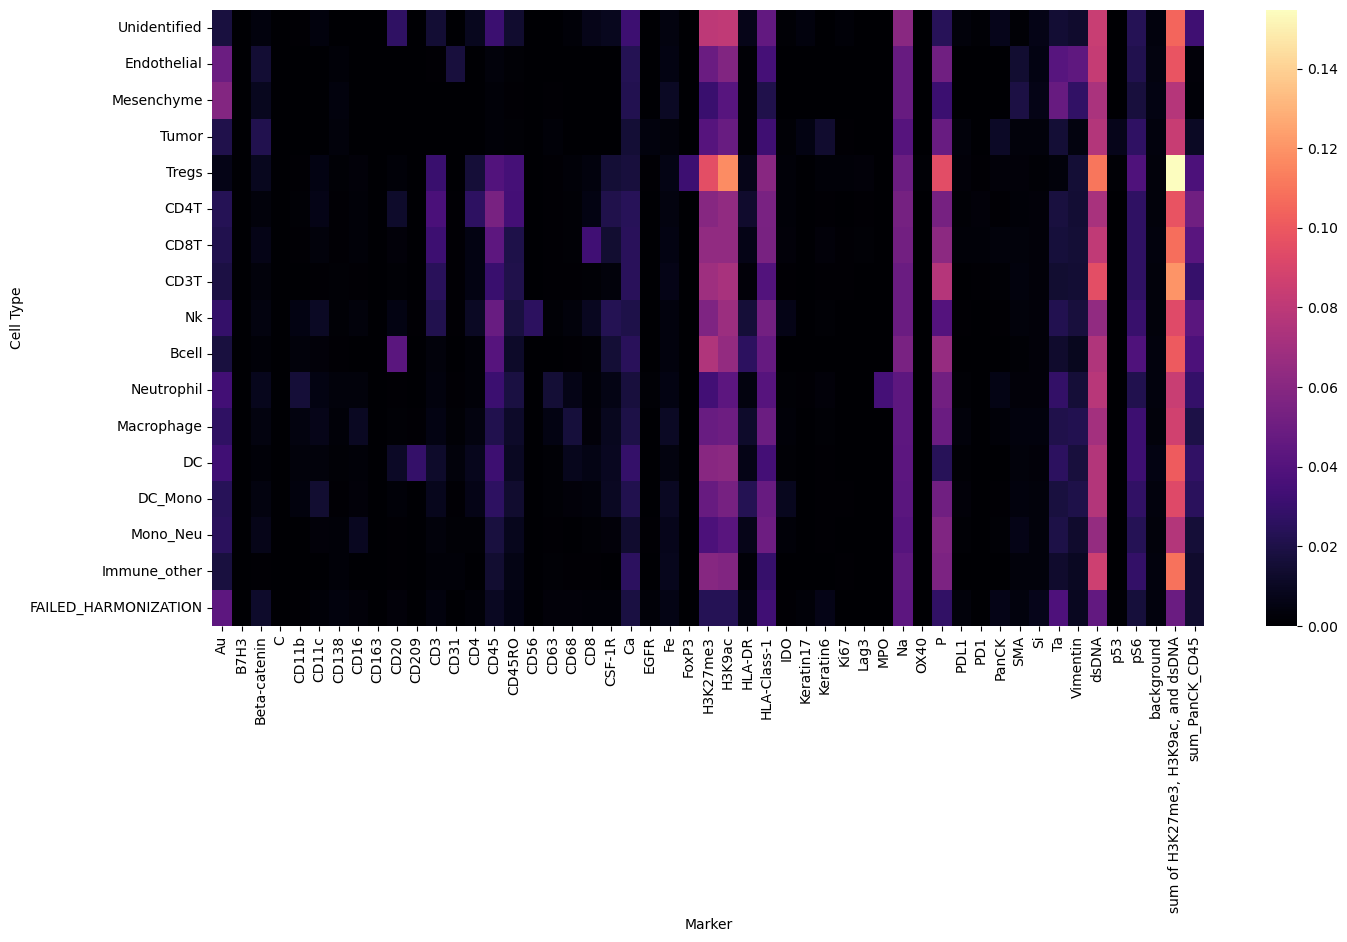

In [6]:
# Change numerical cell type ticks to cell names
y_axis = [metadata['cell_types'][i] for i in range(1, len(metadata['cell_types']))]

# Initialize heatmap and adjust plot
fig, ax = plt.subplots(figsize=(16,8))
s = sns.heatmap(training_data, cmap='magma', yticklabels=y_axis)
s.set(xlabel="Marker", ylabel="Cell Type")
plt.xticks(rotation=90)

# Show the results
plt.show(s)

Using this expression plot, we can deduce which channels are useful for us to keep. To automate the process, we compute the variance for each channel by taking `np.var` along `axis=0` (the columns), then using `np.argsort` to get the indices that would sort the array. To get the 20 channels with the most spread in intensity, we take the 31th element to the end of the array, which gives us an array of the columns/channels that we want to keep. We will call this list `sorting`.

In [7]:
sorting = np.argsort(np.var(training_data.to_numpy(), axis=0))[31:]

### Fully Connected Neural Network in TensorFlow

To generate this fully connected model, I am adapting code from the notebook on [image classification](https://vanvalenlab.github.io/bebi205/notebooks/tf-classifier.html) from the course website. First, I'll define a function that helps generate our training data for the neural network. This training data will take the form of averages for every channel for each cell.

In [8]:
def generate_training_df_NN(list_files):
    '''Generate training data set with averages for each channel per cell.'''
    # Initialize counter for data-generating purposes
    counter = 0
    
    # Iterate through files in list
    for file in tqdm(list_files):
        counter += 1
        X, y, cell_types = get_file(file)
        
        # Normalize X data
        normalized_X = normalize_data(X)

        # Generate training dataframe
        init_tdf = training_DF(normalized_X, y, cell_types)

        # If first file, initialize training dataframe. Otherwise, concatenate
        if counter == 1:
            fin_tdf = init_tdf
        else:
            fin_tdf = pd.concat([fin_tdf, init_tdf], axis=0)
        
    # Set cell type as the index
    final_tdf = fin_tdf.set_index("cell type")
    
    # All columns
    allCols = np.array(list(range(0,51)))
    colstodelete = np.setdiff1d(allCols, sorting)

    # Return dataframe with only desired channels
    final_tdf = final_tdf.drop(final_tdf.columns[colstodelete], axis=1)
    
    # Return data ready for plotting
    return final_tdf

Using this function, let's generate the training data.

In [9]:
trn_data = generate_training_df_NN(npz_data)

100%|███████████████████████████████████████████| 40/40 [03:58<00:00,  5.97s/it]


Let's save our data to a CSV for reference, although we create the data we use to train the model in this notebook.

In [10]:
trn_data.to_csv('trn_data.csv')

Let's implement the rest of the code from the image processing notebook below.

In [11]:
# Define X and y data from the DataFrame
X = trn_data.to_numpy()
y_init = trn_data.index.values
y = tf.keras.utils.to_categorical(y_init)

# Create training, test, and validation datasets
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, train_size=0.8)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size=0.5)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch data
batch_size = 32
train_dataset = train_dataset.shuffle(256).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Define the fully connected neural network
def create_fc_classifier():
    inputs = Input((len(X[0])), # length 20 vector 
                   name='fc_classifier_input')
    x = Flatten()(inputs)
    x = Dense(18)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(18)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(len(y[0]))(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# Create the classifier
fc_classifier = create_fc_classifier()

# Define the loss function
loss_function = tf.keras.losses.CategoricalCrossentropy() 

# Define the training algorithm
fc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=0.001)

# Define training parameters
n_epochs=32

# Define callbacks
fc_model_path = '/data/models/bebi205/fc'
fc_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        fc_model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False)]
fc_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7))

# Compile model
fc_classifier.compile(optimizer=fc_optimizer, 
                          loss=loss_function, 
                          metrics = ['accuracy'])

# Train the fully connected neural network
fc_classifier.fit(train_dataset,
                  validation_data=val_dataset,
                  epochs=n_epochs,
                  verbose=1,
                  callbacks=fc_callbacks);

# Generate predictions
test_list = list(test_dataset.as_numpy_iterator())
X_test = [item[0] for item in test_list]
y_test = [item[1] for item in test_list]

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
y_test = np.argmax(y_test, axis=-1)

y_pred = fc_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

Epoch 1/32


2023-04-24 08:25:34.963019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [163426,20]
	 [[{{node Placeholder/_0}}]]
2023-04-24 08:25:34.963428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [163426,18]
	 [[{{node Placeholder/_1}}]]


5089/5108 [============================>.] - ETA: 0s - loss: 1.2322 - accuracy: 0.6371

2023-04-24 08:25:44.228859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20428,18]
	 [[{{node Placeholder/_1}}]]



Epoch 1: val_loss improved from inf to 1.04844, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 11s 2ms/step - loss: 1.2315 - accuracy: 0.6373 - val_loss: 1.0484 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 2/32
5099/5108 [============================>.] - ETA: 0s - loss: 1.0433 - accuracy: 0.6785
Epoch 2: val_loss improved from 1.04844 to 1.03486, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 1.0431 - accuracy: 0.6785 - val_loss: 1.0349 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 3/32
5097/5108 [============================>.] - ETA: 0s - loss: 1.0138 - accuracy: 0.6871
Epoch 3: val_loss improved from 1.03486 to 1.01648, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 1.0139 - accuracy: 0.6870 - val_loss: 1.0165 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 4/32
5105/5108 [============================>.] - ETA: 0s - loss: 0.9966 - accuracy: 0.6922
Epoch 4: val_loss did not improve from 1.01648
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9967 - accuracy: 0.6922 - val_loss: 1.0424 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 5/32
5096/5108 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.6933
Epoch 5: val_loss did not improve from 1.01648
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9881 - accuracy: 0.6933 - val_loss: 1.1114 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 6/32
5077/5108 [============================>.] - ETA: 0s - loss: 0.9805 - accuracy: 0.6958
Epoch 6: val_loss improved from 1.01648 to 1.01498, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9800 - accuracy: 0.6959 - val_loss: 1.0150 - val_accuracy: 0.6868 - lr: 0.0010
Epoch 7/32
5103/5108 [============================>.] - ETA: 0s - loss: 0.9745 - accuracy: 0.6970
Epoch 7: val_loss did not improve from 1.01498
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9744 - accuracy: 0.6970 - val_loss: 1.0158 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 8/32
5097/5108 [============================>.] - ETA: 0s - loss: 0.9687 - accuracy: 0.6984
Epoch 8: val_loss improved from 1.01498 to 1.00165, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9687 - accuracy: 0.6984 - val_loss: 1.0016 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 9/32
5089/5108 [============================>.] - ETA: 0s - loss: 0.9659 - accuracy: 0.6989
Epoch 9: val_loss improved from 1.00165 to 0.95247, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9658 - accuracy: 0.6989 - val_loss: 0.9525 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 10/32
5100/5108 [============================>.] - ETA: 0s - loss: 0.9613 - accuracy: 0.6993
Epoch 10: val_loss did not improve from 0.95247
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9612 - accuracy: 0.6994 - val_loss: 0.9919 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 11/32
5103/5108 [============================>.] - ETA: 0s - loss: 0.9594 - accuracy: 0.7005
Epoch 11: val_loss did not improve from 0.95247
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9593 - accuracy: 0.7005 - val_loss: 0.9930 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 12/32
5102/5108 [============================>.] - ETA: 0s - loss: 0.9552 - accuracy: 0.7005
Epoch 12: val_loss did not improve from 0.95247

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5108/5108 [==============================]

INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9459 - accuracy: 0.7034 - val_loss: 0.9327 - val_accuracy: 0.7060 - lr: 5.0000e-04
Epoch 14/32
5095/5108 [============================>.] - ETA: 0s - loss: 0.9454 - accuracy: 0.7035
Epoch 14: val_loss improved from 0.93266 to 0.93172, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9453 - accuracy: 0.7035 - val_loss: 0.9317 - val_accuracy: 0.7055 - lr: 5.0000e-04
Epoch 15/32
5101/5108 [============================>.] - ETA: 0s - loss: 0.9422 - accuracy: 0.7047
Epoch 15: val_loss did not improve from 0.93172
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9424 - accuracy: 0.7046 - val_loss: 0.9358 - val_accuracy: 0.7062 - lr: 5.0000e-04
Epoch 16/32
5097/5108 [============================>.] - ETA: 0s - loss: 0.9445 - accuracy: 0.7034
Epoch 16: val_loss did not improve from 0.93172
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9445 - accuracy: 0.7034 - val_loss: 0.9349 - val_accuracy: 0.7062 - lr: 5.0000e-04
Epoch 17/32
5100/5108 [============================>.] - ETA: 0s - loss: 0.9408 - accuracy: 0.7040
Epoch 17: val_loss did not improve from 0.93172

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5108/5108 [===================

INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9377 - accuracy: 0.7049 - val_loss: 0.9191 - val_accuracy: 0.7078 - lr: 2.5000e-04
Epoch 19/32
5098/5108 [============================>.] - ETA: 0s - loss: 0.9382 - accuracy: 0.7047
Epoch 19: val_loss did not improve from 0.91913
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9379 - accuracy: 0.7048 - val_loss: 0.9256 - val_accuracy: 0.7071 - lr: 2.5000e-04
Epoch 20/32
5100/5108 [============================>.] - ETA: 0s - loss: 0.9382 - accuracy: 0.7045
Epoch 20: val_loss did not improve from 0.91913
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9381 - accuracy: 0.7046 - val_loss: 0.9203 - val_accuracy: 0.7069 - lr: 2.5000e-04
Epoch 21/32
5078/5108 [============================>.] - ETA: 0s - loss: 0.9374 - accuracy: 0.7050
Epoch 21: val_loss improved from 0.91913 to 0.91739, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9371 - accuracy: 0.7051 - val_loss: 0.9174 - val_accuracy: 0.7095 - lr: 2.5000e-04
Epoch 22/32
5089/5108 [============================>.] - ETA: 0s - loss: 0.9374 - accuracy: 0.7046
Epoch 22: val_loss improved from 0.91739 to 0.91704, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9373 - accuracy: 0.7047 - val_loss: 0.9170 - val_accuracy: 0.7099 - lr: 2.5000e-04
Epoch 23/32
5080/5108 [============================>.] - ETA: 0s - loss: 0.9357 - accuracy: 0.7053
Epoch 23: val_loss did not improve from 0.91704
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9355 - accuracy: 0.7054 - val_loss: 0.9304 - val_accuracy: 0.7067 - lr: 2.5000e-04
Epoch 24/32
5091/5108 [============================>.] - ETA: 0s - loss: 0.9351 - accuracy: 0.7057
Epoch 24: val_loss improved from 0.91704 to 0.91568, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9349 - accuracy: 0.7057 - val_loss: 0.9157 - val_accuracy: 0.7110 - lr: 2.5000e-04
Epoch 25/32
5082/5108 [============================>.] - ETA: 0s - loss: 0.9335 - accuracy: 0.7049
Epoch 25: val_loss did not improve from 0.91568
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9334 - accuracy: 0.7050 - val_loss: 0.9160 - val_accuracy: 0.7099 - lr: 2.5000e-04
Epoch 26/32
5105/5108 [============================>.] - ETA: 0s - loss: 0.9351 - accuracy: 0.7054
Epoch 26: val_loss improved from 0.91568 to 0.91214, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9350 - accuracy: 0.7054 - val_loss: 0.9121 - val_accuracy: 0.7121 - lr: 2.5000e-04
Epoch 27/32
5084/5108 [============================>.] - ETA: 0s - loss: 0.9345 - accuracy: 0.7065
Epoch 27: val_loss did not improve from 0.91214
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9344 - accuracy: 0.7065 - val_loss: 0.9242 - val_accuracy: 0.7079 - lr: 2.5000e-04
Epoch 28/32
5100/5108 [============================>.] - ETA: 0s - loss: 0.9333 - accuracy: 0.7053
Epoch 28: val_loss did not improve from 0.91214
5108/5108 [==============================] - 9s 2ms/step - loss: 0.9332 - accuracy: 0.7054 - val_loss: 0.9143 - val_accuracy: 0.7113 - lr: 2.5000e-04
Epoch 29/32
5096/5108 [============================>.] - ETA: 0s - loss: 0.9335 - accuracy: 0.7056
Epoch 29: val_loss did not improve from 0.91214

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
5108/5108 [===================

INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9298 - accuracy: 0.7078 - val_loss: 0.9095 - val_accuracy: 0.7111 - lr: 1.2500e-04
Epoch 31/32
5091/5108 [============================>.] - ETA: 0s - loss: 0.9281 - accuracy: 0.7076
Epoch 31: val_loss improved from 0.90950 to 0.90886, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9280 - accuracy: 0.7076 - val_loss: 0.9089 - val_accuracy: 0.7117 - lr: 1.2500e-04
Epoch 32/32
5093/5108 [============================>.] - ETA: 0s - loss: 0.9289 - accuracy: 0.7078
Epoch 32: val_loss improved from 0.90886 to 0.90816, saving model to /data/models/bebi205/fc


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


INFO:tensorflow:Assets written to: /data/models/bebi205/fc/assets


5108/5108 [==============================] - 10s 2ms/step - loss: 0.9287 - accuracy: 0.7078 - val_loss: 0.9082 - val_accuracy: 0.7113 - lr: 1.2500e-04


2023-04-24 08:30:36.592026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20429,18]
	 [[{{node Placeholder/_1}}]]


639/639 [==============================] - 1s 1ms/step


Now, we can plot the confusion matrix for the fully connected classifier using `sklearn.metrics.confusion_matrix`.

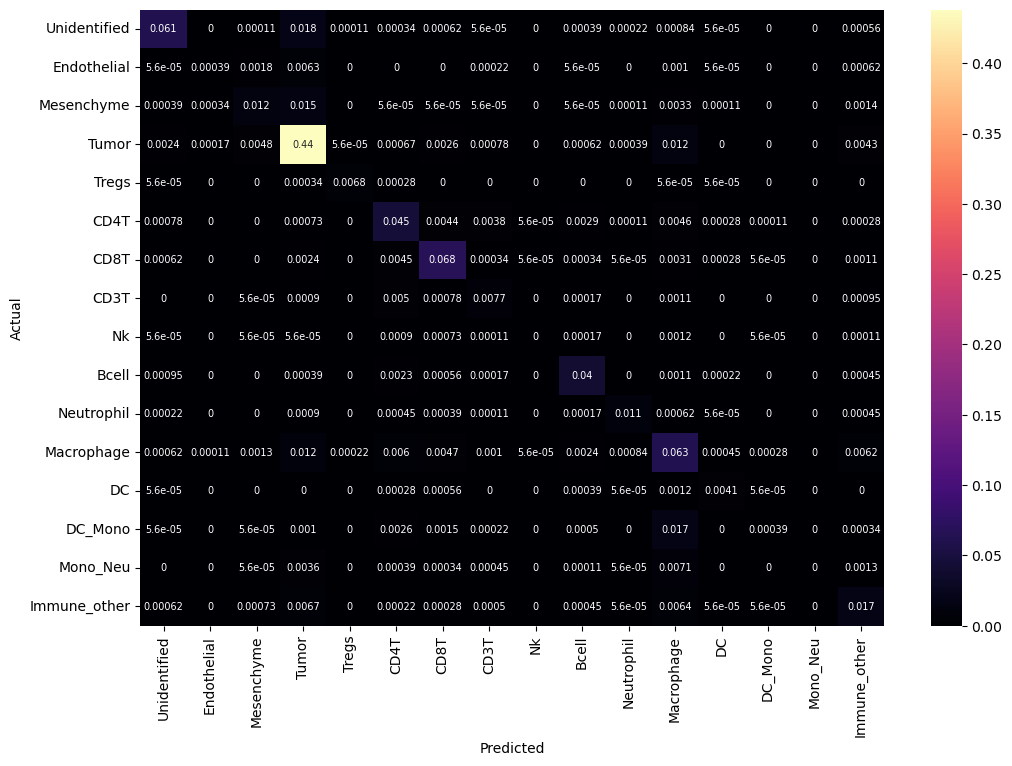

In [12]:
# Compute confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)

# Delete FAILED_HARMONIZATION
cm_v2 = np.delete(cm, -1, 0) 
cm_v2 = np.delete(cm_v2, -1, 1)

# Normalize
cm_v2 = cm_v2 / np.sum(cm_v2)

# Map tick numbers to cell labels
axis_ticks = [metadata['cell_types'][i] for i in range(1, len(cm_v2) + 1)]

# Initialize and show figure
plt.figure(figsize = (12,8))
s = sns.heatmap(cm_v2, annot=True, annot_kws={"size": 7}, cmap="magma")
s.set(xlabel="Predicted", ylabel="Actual", xticklabels=axis_ticks, yticklabels=axis_ticks)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Linear Classifier in PyTorch

We will follow the aforementioned tutorial to build our linear classifier in PyTorch.

In [13]:
# Initialize X and y as before
X = trn_data.to_numpy()
y_init = trn_data.index.values
y = tf.keras.utils.to_categorical(y_init)

# Convert data into tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split data for training, testing, and validation
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, train_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True)

In [14]:
# Build cell type classifier
class CellClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(len(X[0]), len(X[0]) - 5)
        self.activation = nn.ReLU()
        self.output = nn.Linear(len(X[0]) - 5, len(y[0]))

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return torch.nn.functional.softmax(x, dim=None)

In [15]:
# Loss function and optimizer
model = CellClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize epochs and batch size
n_epochs = 100
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Initialize best accuracy to continually watch it
best_acc = - np.inf
best_weights = None

# Initialize lists for storing data
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = [], [], [], []

In [16]:
# Training loop
for epoch in range(n_epochs):
    
    # Initialize lists for each epoch
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode
    model.train()
    
    # Iterate through batches
    with trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            
            # Grab a batch
            initial = i * batch_size
            X_batch = X_train[initial:initial + batch_size]
            y_batch = y_train[initial:initial + batch_size]

            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    # Set model in evaluation mode
    model.eval()

    # Compute prediction
    y_pred = model(X_val)
    loss_test = loss_fn(y_pred, y_val)
    acc_test = (torch.argmax(y_pred, 1) == torch.argmax(y_val, 1)).float().mean()

    loss_test = float(loss_test)
    acc_test = float(acc_test)

    # Append accuracy and loss data to lists for training and validation
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(loss_test)
    test_acc_hist.append(acc_test)

    # Update the model if accuracy is improved
    if acc > best_acc:
        best_acc = acc
        torch.save(model, 'linear_model.pth')
    print(f"Epoch {epoch} validation: Cross-entropy={loss_test}, Accuracy={acc_test}")

Epoch 0:   0%|                                       | 0/957 [00:00<?, ?batch/s]/tmp/ipykernel_48874/3046023412.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x, dim=None)
Epoch 0: 100%|██████| 957/957 [00:02<00:00, 332.45batch/s, acc=0.375, loss=2.61]


Epoch 0 validation: Cross-entropy=2.5659947395324707, Accuracy=0.41557225584983826


Epoch 1: 100%|██████| 957/957 [00:02<00:00, 336.53batch/s, acc=0.375, loss=2.61]


Epoch 1 validation: Cross-entropy=2.56597900390625, Accuracy=0.41557225584983826


Epoch 2: 100%|██████| 957/957 [00:02<00:00, 337.33batch/s, acc=0.375, loss=2.61]


Epoch 2 validation: Cross-entropy=2.5659759044647217, Accuracy=0.41557225584983826


Epoch 3: 100%|██████| 957/957 [00:02<00:00, 335.55batch/s, acc=0.375, loss=2.61]


Epoch 3 validation: Cross-entropy=2.5659313201904297, Accuracy=0.41557225584983826


Epoch 4: 100%|██████| 957/957 [00:02<00:00, 337.99batch/s, acc=0.656, loss=2.37]


Epoch 4 validation: Cross-entropy=2.4072980880737305, Accuracy=0.5823158621788025


Epoch 5: 100%|██████| 957/957 [00:02<00:00, 336.10batch/s, acc=0.609, loss=2.35]


Epoch 5 validation: Cross-entropy=2.3926234245300293, Accuracy=0.5941342115402222


Epoch 6: 100%|██████| 957/957 [00:02<00:00, 342.87batch/s, acc=0.672, loss=2.33]


Epoch 6 validation: Cross-entropy=2.3663361072540283, Accuracy=0.6224422454833984


Epoch 7: 100%|██████| 957/957 [00:02<00:00, 341.55batch/s, acc=0.672, loss=2.32]


Epoch 7 validation: Cross-entropy=2.3569812774658203, Accuracy=0.630050778388977


Epoch 8: 100%|██████| 957/957 [00:02<00:00, 339.39batch/s, acc=0.672, loss=2.31]


Epoch 8 validation: Cross-entropy=2.35312557220459, Accuracy=0.6329458951950073


Epoch 9: 100%|██████| 957/957 [00:02<00:00, 341.46batch/s, acc=0.672, loss=2.31]


Epoch 9 validation: Cross-entropy=2.3508968353271484, Accuracy=0.6343585252761841


Epoch 10: 100%|██████| 957/957 [00:02<00:00, 342.56batch/s, acc=0.688, loss=2.3]


Epoch 10 validation: Cross-entropy=2.3489797115325928, Accuracy=0.6355473399162292


Epoch 11: 100%|██████| 957/957 [00:02<00:00, 342.65batch/s, acc=0.688, loss=2.3]


Epoch 11 validation: Cross-entropy=2.3480606079101562, Accuracy=0.6361487507820129


Epoch 12: 100%|██████| 957/957 [00:02<00:00, 338.79batch/s, acc=0.688, loss=2.3]


Epoch 12 validation: Cross-entropy=2.347454786300659, Accuracy=0.6366662383079529


Epoch 13: 100%|██████| 957/957 [00:02<00:00, 336.72batch/s, acc=0.688, loss=2.3]


Epoch 13 validation: Cross-entropy=2.3468892574310303, Accuracy=0.636959969997406


Epoch 14: 100%|██████| 957/957 [00:02<00:00, 339.75batch/s, acc=0.688, loss=2.3]


Epoch 14 validation: Cross-entropy=2.3457560539245605, Accuracy=0.6376872658729553


Epoch 15: 100%|██████| 957/957 [00:02<00:00, 334.39batch/s, acc=0.688, loss=2.3]


Epoch 15 validation: Cross-entropy=2.345597982406616, Accuracy=0.6377431750297546


Epoch 16: 100%|██████| 957/957 [00:02<00:00, 334.41batch/s, acc=0.688, loss=2.3]


Epoch 16 validation: Cross-entropy=2.3447492122650146, Accuracy=0.638372540473938


Epoch 17: 100%|██████| 957/957 [00:02<00:00, 339.20batch/s, acc=0.688, loss=2.3]


Epoch 17 validation: Cross-entropy=2.3440229892730713, Accuracy=0.638806164264679


Epoch 18: 100%|██████| 957/957 [00:02<00:00, 341.20batch/s, acc=0.688, loss=2.3]


Epoch 18 validation: Cross-entropy=2.3434929847717285, Accuracy=0.639463484287262


Epoch 19: 100%|██████| 957/957 [00:02<00:00, 340.52batch/s, acc=0.688, loss=2.3]


Epoch 19 validation: Cross-entropy=2.3431625366210938, Accuracy=0.6395054459571838


Epoch 20: 100%|██████| 957/957 [00:02<00:00, 334.61batch/s, acc=0.688, loss=2.3]


Epoch 20 validation: Cross-entropy=2.341099500656128, Accuracy=0.6434355974197388


Epoch 21: 100%|██████| 957/957 [00:02<00:00, 330.73batch/s, acc=0.688, loss=2.3]


Epoch 21 validation: Cross-entropy=2.340076446533203, Accuracy=0.6446383595466614


Epoch 22: 100%|██████| 957/957 [00:02<00:00, 343.85batch/s, acc=0.688, loss=2.3]


Epoch 22 validation: Cross-entropy=2.3391942977905273, Accuracy=0.6447782516479492


Epoch 23: 100%|██████| 957/957 [00:02<00:00, 338.61batch/s, acc=0.688, loss=2.3]


Epoch 23 validation: Cross-entropy=2.3388726711273193, Accuracy=0.6449460983276367


Epoch 24: 100%|██████| 957/957 [00:02<00:00, 336.85batch/s, acc=0.688, loss=2.3]


Epoch 24 validation: Cross-entropy=2.338624954223633, Accuracy=0.6453097462654114


Epoch 25: 100%|██████| 957/957 [00:02<00:00, 340.16batch/s, acc=0.688, loss=2.3]


Epoch 25 validation: Cross-entropy=2.337872266769409, Accuracy=0.6458691954612732


Epoch 26: 100%|██████| 957/957 [00:02<00:00, 339.10batch/s, acc=0.688, loss=2.3]


Epoch 26 validation: Cross-entropy=2.337686061859131, Accuracy=0.645855188369751


Epoch 27: 100%|██████| 957/957 [00:02<00:00, 341.07batch/s, acc=0.688, loss=2.3]


Epoch 27 validation: Cross-entropy=2.3373234272003174, Accuracy=0.6461628675460815


Epoch 28: 100%|██████| 957/957 [00:02<00:00, 337.70batch/s, acc=0.688, loss=2.3]


Epoch 28 validation: Cross-entropy=2.3371121883392334, Accuracy=0.6462188363075256


Epoch 29: 100%|██████| 957/957 [00:02<00:00, 339.71batch/s, acc=0.688, loss=2.3]


Epoch 29 validation: Cross-entropy=2.33699107170105, Accuracy=0.646330714225769


Epoch 30: 100%|██████| 957/957 [00:02<00:00, 340.57batch/s, acc=0.688, loss=2.3]


Epoch 30 validation: Cross-entropy=2.3367817401885986, Accuracy=0.646428644657135


Epoch 31: 100%|██████| 957/957 [00:02<00:00, 341.72batch/s, acc=0.688, loss=2.3]


Epoch 31 validation: Cross-entropy=2.3367135524749756, Accuracy=0.6466943621635437


Epoch 32: 100%|██████| 957/957 [00:02<00:00, 340.43batch/s, acc=0.688, loss=2.3]


Epoch 32 validation: Cross-entropy=2.3367483615875244, Accuracy=0.6464706063270569


Epoch 33: 100%|██████| 957/957 [00:02<00:00, 340.89batch/s, acc=0.688, loss=2.3]


Epoch 33 validation: Cross-entropy=2.3365890979766846, Accuracy=0.6464845538139343


Epoch 34: 100%|██████| 957/957 [00:02<00:00, 341.89batch/s, acc=0.688, loss=2.3]


Epoch 34 validation: Cross-entropy=2.3364644050598145, Accuracy=0.6464565992355347


Epoch 35: 100%|██████| 957/957 [00:02<00:00, 342.06batch/s, acc=0.688, loss=2.3]


Epoch 35 validation: Cross-entropy=2.3365936279296875, Accuracy=0.6465544700622559


Epoch 36: 100%|██████| 957/957 [00:02<00:00, 335.82batch/s, acc=0.688, loss=2.3]


Epoch 36 validation: Cross-entropy=2.336284875869751, Accuracy=0.6466803550720215


Epoch 37: 100%|██████| 957/957 [00:02<00:00, 333.65batch/s, acc=0.688, loss=2.3]


Epoch 37 validation: Cross-entropy=2.33644437789917, Accuracy=0.6467642784118652


Epoch 38: 100%|██████| 957/957 [00:02<00:00, 336.36batch/s, acc=0.688, loss=2.3]


Epoch 38 validation: Cross-entropy=2.3361380100250244, Accuracy=0.6469041705131531


Epoch 39: 100%|██████| 957/957 [00:02<00:00, 333.34batch/s, acc=0.688, loss=2.3]


Epoch 39 validation: Cross-entropy=2.3361942768096924, Accuracy=0.6470160484313965


Epoch 40: 100%|██████| 957/957 [00:02<00:00, 342.08batch/s, acc=0.688, loss=2.3]


Epoch 40 validation: Cross-entropy=2.336477518081665, Accuracy=0.6467363238334656


Epoch 41: 100%|██████| 957/957 [00:02<00:00, 337.47batch/s, acc=0.688, loss=2.3]


Epoch 41 validation: Cross-entropy=2.3364086151123047, Accuracy=0.6465544700622559


Epoch 42: 100%|██████| 957/957 [00:02<00:00, 337.42batch/s, acc=0.688, loss=2.3]


Epoch 42 validation: Cross-entropy=2.33632755279541, Accuracy=0.646848201751709


Epoch 43: 100%|██████| 957/957 [00:02<00:00, 338.56batch/s, acc=0.688, loss=2.3]


Epoch 43 validation: Cross-entropy=2.33768630027771, Accuracy=0.6452397704124451


Epoch 44: 100%|██████| 957/957 [00:02<00:00, 340.24batch/s, acc=0.688, loss=2.3]


Epoch 44 validation: Cross-entropy=2.3377175331115723, Accuracy=0.6452817320823669


Epoch 45: 100%|██████| 957/957 [00:02<00:00, 341.23batch/s, acc=0.688, loss=2.3]


Epoch 45 validation: Cross-entropy=2.337916135787964, Accuracy=0.6447502970695496


Epoch 46: 100%|██████| 957/957 [00:02<00:00, 347.01batch/s, acc=0.688, loss=2.3]


Epoch 46 validation: Cross-entropy=2.3359758853912354, Accuracy=0.6465684771537781


Epoch 47: 100%|██████| 957/957 [00:02<00:00, 343.20batch/s, acc=0.688, loss=2.3]


Epoch 47 validation: Cross-entropy=2.3368990421295166, Accuracy=0.6453936696052551


Epoch 48: 100%|██████| 957/957 [00:02<00:00, 346.38batch/s, acc=0.688, loss=2.3]


Epoch 48 validation: Cross-entropy=2.3359317779541016, Accuracy=0.646190881729126


Epoch 49: 100%|██████| 957/957 [00:02<00:00, 337.97batch/s, acc=0.688, loss=2.3]


Epoch 49 validation: Cross-entropy=2.335893154144287, Accuracy=0.6463027596473694


Epoch 50: 100%|██████| 957/957 [00:02<00:00, 334.20batch/s, acc=0.688, loss=2.3]


Epoch 50 validation: Cross-entropy=2.3353097438812256, Accuracy=0.6470719575881958


Epoch 51: 100%|██████| 957/957 [00:02<00:00, 339.01batch/s, acc=0.688, loss=2.3]


Epoch 51 validation: Cross-entropy=2.334315538406372, Accuracy=0.647659420967102


Epoch 52: 100%|█████| 957/957 [00:02<00:00, 338.53batch/s, acc=0.688, loss=2.29]


Epoch 52 validation: Cross-entropy=2.334357500076294, Accuracy=0.647939145565033


Epoch 53: 100%|██████| 957/957 [00:02<00:00, 342.84batch/s, acc=0.688, loss=2.3]


Epoch 53 validation: Cross-entropy=2.3343234062194824, Accuracy=0.6479111313819885


Epoch 54: 100%|██████| 957/957 [00:02<00:00, 344.26batch/s, acc=0.688, loss=2.3]


Epoch 54 validation: Cross-entropy=2.334345579147339, Accuracy=0.6478971838951111


Epoch 55: 100%|█████| 957/957 [00:02<00:00, 338.44batch/s, acc=0.688, loss=2.29]


Epoch 55 validation: Cross-entropy=2.3344640731811523, Accuracy=0.6475335359573364


Epoch 56: 100%|█████| 957/957 [00:02<00:00, 339.19batch/s, acc=0.688, loss=2.29]


Epoch 56 validation: Cross-entropy=2.3345937728881836, Accuracy=0.6472538113594055


Epoch 57: 100%|█████| 957/957 [00:02<00:00, 336.09batch/s, acc=0.688, loss=2.29]


Epoch 57 validation: Cross-entropy=2.334261655807495, Accuracy=0.6477153301239014


Epoch 58: 100%|██████| 957/957 [00:02<00:00, 339.85batch/s, acc=0.688, loss=2.3]


Epoch 58 validation: Cross-entropy=2.3348500728607178, Accuracy=0.6470999717712402


Epoch 59: 100%|██████| 957/957 [00:02<00:00, 336.60batch/s, acc=0.688, loss=2.3]


Epoch 59 validation: Cross-entropy=2.334930658340454, Accuracy=0.6470440030097961


Epoch 60: 100%|██████| 957/957 [00:02<00:00, 333.32batch/s, acc=0.688, loss=2.3]


Epoch 60 validation: Cross-entropy=2.3349990844726562, Accuracy=0.6469041705131531


Epoch 61: 100%|██████| 957/957 [00:02<00:00, 331.35batch/s, acc=0.688, loss=2.3]


Epoch 61 validation: Cross-entropy=2.334711790084839, Accuracy=0.647323727607727


Epoch 62: 100%|██████| 957/957 [00:02<00:00, 338.83batch/s, acc=0.688, loss=2.3]


Epoch 62 validation: Cross-entropy=2.3348324298858643, Accuracy=0.6472398042678833


Epoch 63: 100%|██████| 957/957 [00:02<00:00, 337.76batch/s, acc=0.688, loss=2.3]


Epoch 63 validation: Cross-entropy=2.334878444671631, Accuracy=0.6472398042678833


Epoch 64: 100%|██████| 957/957 [00:02<00:00, 344.32batch/s, acc=0.688, loss=2.3]


Epoch 64 validation: Cross-entropy=2.3343679904937744, Accuracy=0.647603452205658


Epoch 65: 100%|██████| 957/957 [00:02<00:00, 339.29batch/s, acc=0.688, loss=2.3]


Epoch 65 validation: Cross-entropy=2.3344101905822754, Accuracy=0.6474496126174927


Epoch 66: 100%|██████| 957/957 [00:02<00:00, 340.44batch/s, acc=0.688, loss=2.3]


Epoch 66 validation: Cross-entropy=2.333798885345459, Accuracy=0.6479530930519104


Epoch 67: 100%|██████| 957/957 [00:02<00:00, 341.34batch/s, acc=0.688, loss=2.3]


Epoch 67 validation: Cross-entropy=2.334740161895752, Accuracy=0.6470020413398743


Epoch 68: 100%|██████| 957/957 [00:02<00:00, 334.54batch/s, acc=0.688, loss=2.3]


Epoch 68 validation: Cross-entropy=2.3347909450531006, Accuracy=0.6470160484313965


Epoch 69: 100%|██████| 957/957 [00:02<00:00, 341.37batch/s, acc=0.688, loss=2.3]


Epoch 69 validation: Cross-entropy=2.334808111190796, Accuracy=0.646848201751709


Epoch 70: 100%|██████| 957/957 [00:02<00:00, 339.93batch/s, acc=0.688, loss=2.3]


Epoch 70 validation: Cross-entropy=2.3343706130981445, Accuracy=0.6472118496894836


Epoch 71: 100%|██████| 957/957 [00:02<00:00, 336.50batch/s, acc=0.688, loss=2.3]


Epoch 71 validation: Cross-entropy=2.3337252140045166, Accuracy=0.6482328176498413


Epoch 72: 100%|██████| 957/957 [00:02<00:00, 344.17batch/s, acc=0.688, loss=2.3]


Epoch 72 validation: Cross-entropy=2.334177255630493, Accuracy=0.6474356055259705


Epoch 73:  82%|████ | 780/957 [00:02<00:00, 346.79batch/s, acc=0.781, loss=2.21]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 74: 100%|██████| 957/957 [00:02<00:00, 332.92batch/s, acc=0.688, loss=2.3]


Epoch 74 validation: Cross-entropy=2.334084987640381, Accuracy=0.6475335359573364


Epoch 75: 100%|██████| 957/957 [00:02<00:00, 339.32batch/s, acc=0.688, loss=2.3]


Epoch 75 validation: Cross-entropy=2.334275484085083, Accuracy=0.6472538113594055


Epoch 76: 100%|██████| 957/957 [00:02<00:00, 337.24batch/s, acc=0.688, loss=2.3]


Epoch 76 validation: Cross-entropy=2.3337128162384033, Accuracy=0.6479671001434326


Epoch 77: 100%|██████| 957/957 [00:02<00:00, 338.76batch/s, acc=0.688, loss=2.3]


Epoch 77 validation: Cross-entropy=2.3337666988372803, Accuracy=0.6479530930519104


Epoch 78: 100%|██████| 957/957 [00:02<00:00, 330.96batch/s, acc=0.688, loss=2.3]


Epoch 78 validation: Cross-entropy=2.3340439796447754, Accuracy=0.6477013826370239


Epoch 79: 100%|██████| 957/957 [00:02<00:00, 341.30batch/s, acc=0.688, loss=2.3]


Epoch 79 validation: Cross-entropy=2.3339688777923584, Accuracy=0.6477013826370239


Epoch 80: 100%|██████| 957/957 [00:02<00:00, 342.73batch/s, acc=0.688, loss=2.3]


Epoch 80 validation: Cross-entropy=2.3338115215301514, Accuracy=0.6479950547218323


Epoch 81: 100%|██████| 957/957 [00:02<00:00, 345.34batch/s, acc=0.688, loss=2.3]


Epoch 81 validation: Cross-entropy=2.3334591388702393, Accuracy=0.647939145565033


Epoch 82:   8%|▍     | 74/957 [00:00<00:02, 330.17batch/s, acc=0.703, loss=2.29]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 82: 100%|██████| 957/957 [00:02<00:00, 339.50batch/s, acc=0.688, loss=2.3]


Epoch 82 validation: Cross-entropy=2.3331494331359863, Accuracy=0.6484845876693726


Epoch 83: 100%|██████| 957/957 [00:02<00:00, 335.86batch/s, acc=0.688, loss=2.3]


Epoch 83 validation: Cross-entropy=2.332897901535034, Accuracy=0.6486524343490601


Epoch 84: 100%|██████| 957/957 [00:02<00:00, 319.28batch/s, acc=0.672, loss=2.3]


Epoch 84 validation: Cross-entropy=2.3331756591796875, Accuracy=0.6483027935028076


Epoch 85: 100%|██████| 957/957 [00:02<00:00, 330.11batch/s, acc=0.672, loss=2.3]


Epoch 85 validation: Cross-entropy=2.333664655685425, Accuracy=0.6478272676467896


Epoch 86: 100%|██████| 957/957 [00:02<00:00, 334.71batch/s, acc=0.688, loss=2.3]


Epoch 86 validation: Cross-entropy=2.3331992626190186, Accuracy=0.6484286785125732


Epoch 87: 100%|██████| 957/957 [00:02<00:00, 338.59batch/s, acc=0.688, loss=2.3]


Epoch 87 validation: Cross-entropy=2.3326363563537598, Accuracy=0.6488202810287476


Epoch 88: 100%|██████| 957/957 [00:02<00:00, 339.82batch/s, acc=0.672, loss=2.3]


Epoch 88 validation: Cross-entropy=2.332435131072998, Accuracy=0.6491559147834778


Epoch 89: 100%|██████| 957/957 [00:02<00:00, 349.02batch/s, acc=0.672, loss=2.3]


Epoch 89 validation: Cross-entropy=2.3323967456817627, Accuracy=0.6489601135253906


Epoch 90:  72%|███▌ | 685/957 [00:02<00:00, 340.89batch/s, acc=0.656, loss=2.33]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 91: 100%|██████| 957/957 [00:02<00:00, 328.26batch/s, acc=0.672, loss=2.3]


Epoch 91 validation: Cross-entropy=2.3320980072021484, Accuracy=0.6492958068847656


Epoch 92: 100%|██████| 957/957 [00:02<00:00, 323.68batch/s, acc=0.672, loss=2.3]


Epoch 92 validation: Cross-entropy=2.331869602203369, Accuracy=0.649743378162384


Epoch 93: 100%|██████| 957/957 [00:02<00:00, 326.85batch/s, acc=0.688, loss=2.3]


Epoch 93 validation: Cross-entropy=2.331712484359741, Accuracy=0.6499111652374268


Epoch 94: 100%|██████| 957/957 [00:02<00:00, 329.60batch/s, acc=0.688, loss=2.3]


Epoch 94 validation: Cross-entropy=2.331686019897461, Accuracy=0.6498972177505493


Epoch 95: 100%|██████| 957/957 [00:02<00:00, 332.94batch/s, acc=0.688, loss=2.3]


Epoch 95 validation: Cross-entropy=2.3315348625183105, Accuracy=0.6498972177505493


Epoch 96: 100%|██████| 957/957 [00:02<00:00, 335.07batch/s, acc=0.688, loss=2.3]


Epoch 96 validation: Cross-entropy=2.332099437713623, Accuracy=0.6495335698127747


Epoch 97: 100%|██████| 957/957 [00:02<00:00, 338.93batch/s, acc=0.688, loss=2.3]


Epoch 97 validation: Cross-entropy=2.3317153453826904, Accuracy=0.649827241897583


Epoch 98: 100%|██████| 957/957 [00:02<00:00, 349.26batch/s, acc=0.688, loss=2.3]


Epoch 98 validation: Cross-entropy=2.332036018371582, Accuracy=0.6491139531135559


Epoch 99: 100%|██████| 957/957 [00:02<00:00, 345.05batch/s, acc=0.688, loss=2.3]


Epoch 99 validation: Cross-entropy=2.3316402435302734, Accuracy=0.649925172328949


In [17]:
# Restore best model
model = torch.load('linear_model.pth')

# Compute predictions
y_pred = model(X_test)
y_pred = np.argmax(y_pred.detach().numpy(), axis=-1)

# Get predictions for test data
y_test_fin = np.argmax(y_test.detach().numpy(), axis=-1)

/tmp/ipykernel_48874/3046023412.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x, dim=None)


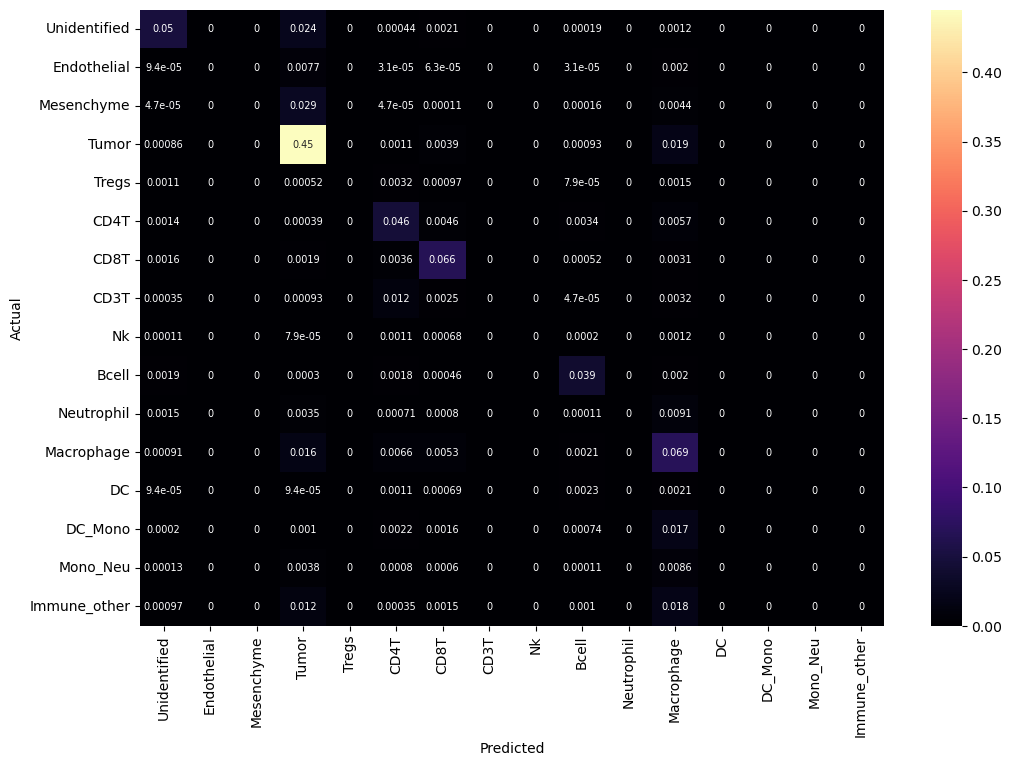

In [18]:
# Generate confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test_fin, y_pred)
cm_v2 = np.delete(cm, -1, 0)
cm_v2 = np.delete(cm_v2, -1, 1)
cm_v2 = cm_v2 / np.sum(cm_v2)

# Plot the confusion matrix
axis_ticks = [metadata['cell_types'][i] for i in range(1, len(cm_v2) + 1)]
plt.figure(figsize = (12,8))
s = sns.heatmap(cm_v2, annot=True, annot_kws={"size": 7}, cmap="magma")
s.set(xlabel="Predicted", ylabel="Actual", xticklabels=axis_ticks, yticklabels=axis_ticks)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Let's also plot the loss and accuracy data to see how it evolves from epoch to epoch.

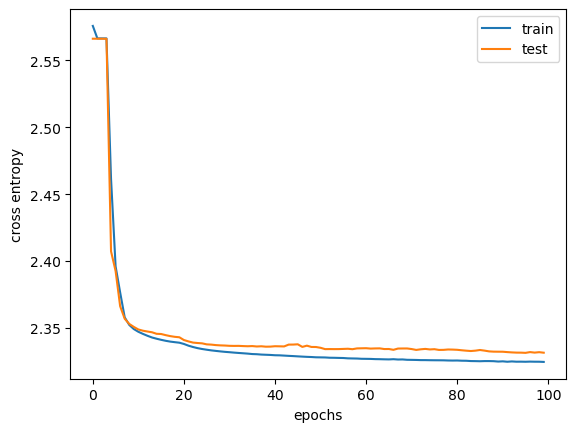

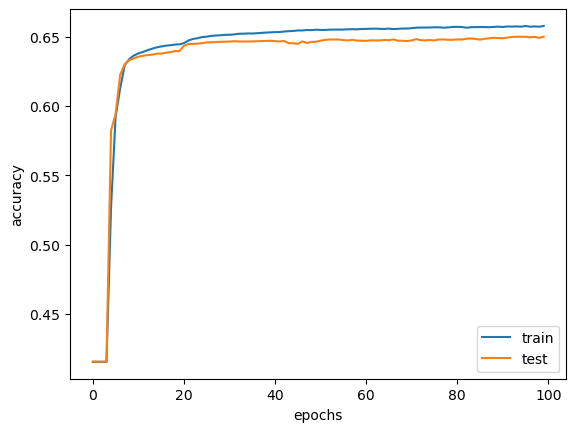

In [19]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Last thing we need is a function that accepts an X and y, preprocesses data, passes it through our model, and returns a dictionary mapping the segmentation mask IDs to celltype codes.

In [20]:
def generate_dict(X, y):
    '''Take in X and y, preprocesses data, passes it through our model, and
    returns a dictionary mapping segmentation mask IDs to celltype codes.'''
    
    # Normalize data
    flattened_X = np.reshape(X[0], (X[0].shape[0]*X[0].shape[1], X[0].shape[2]))
    maxValsX = np.max(flattened_X, axis=0)
    maxValsX[maxValsX == 0] = 1
    normalized_X = X / maxValsX

    # Retrieve nuclear segmentation data
    cellData = y[0,...,0]
    
    # Create DataFrame of mean intensities
    df1 = pd.DataFrame(
    measure.regionprops_table(cellData, 
                              intensity_image=normalized_X[0], 
                              properties=['label','mean_intensity'],
    )).set_index('label')
    
    # Add channel names
    dictChannels = {}
    for j in range(len(metadata['channels'])):
        dictChannels[df1.columns.values[j]] = metadata['channels'][j]

    # Rename columns to channel names
    final_tdf = df1.rename(columns=dictChannels)
    
    # All columns
    allCols = np.array(list(range(0,51)))
    toKeep = np.array([10, 27, 20, 19, 24, 34, 44, 15, 28, 43,  9, 11,  0, 45, 50, 14, 37,
       25, 26, 49]) # from sorting performed earlier
    colstodelete = np.setdiff1d(allCols, toKeep)

    # Return dataframe with only desired channels
    final_tdf = final_tdf.drop(final_tdf.columns[colstodelete], axis=1)
    
    # Initialize X and y as before
    X_test = final_tdf.to_numpy()

    # Convert data into tensors
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # Restore best linear model
    model = torch.load('linear_model.pth')
    
    # Pass data through model
    y_pred_test = model(X_test)
    y_pred_test = np.argmax(y_pred_test.detach().numpy(), axis=-1)
    
    # Create and return dictionary
    test_keys = np.arange(1, len(y_pred_test))
    res = dict(zip(test_keys, y_pred_test))
    return res